# Configure Merge Module Params

This notebook should be used as a test for ensuring correct merge parameters before merge processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## SET PARAMETERS

### Fixed parameters for merge processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd

from lib.shared.file_utils import get_filename
from lib.shared.configuration_utils import (
    plot_combined_tile_grid,
    plot_merge_example,
    CONFIG_FILE_HEADER,
)
from lib.merge.hash import hash_process_info, find_triangles, initial_alignment
from lib.merge.eval_alignment import plot_alignment_quality

## SET PARAMETERS

### Parameters for testing merge processing

- `TEST_WELL`, `TEST_TILE`: Well used for configuring parameters in this notebook.

### Parameters for metadata extraction

- `SBS_METADATA_CYCLE`: Cycle used for extracting SBS data. Usually first cycle.

In [3]:
# TODO: Figure out good way to use testing data for example analysis...
# for now just use copied files from denali screen

TEST_WELL = "A1"
SBS_METADATA_CYCLE = 1

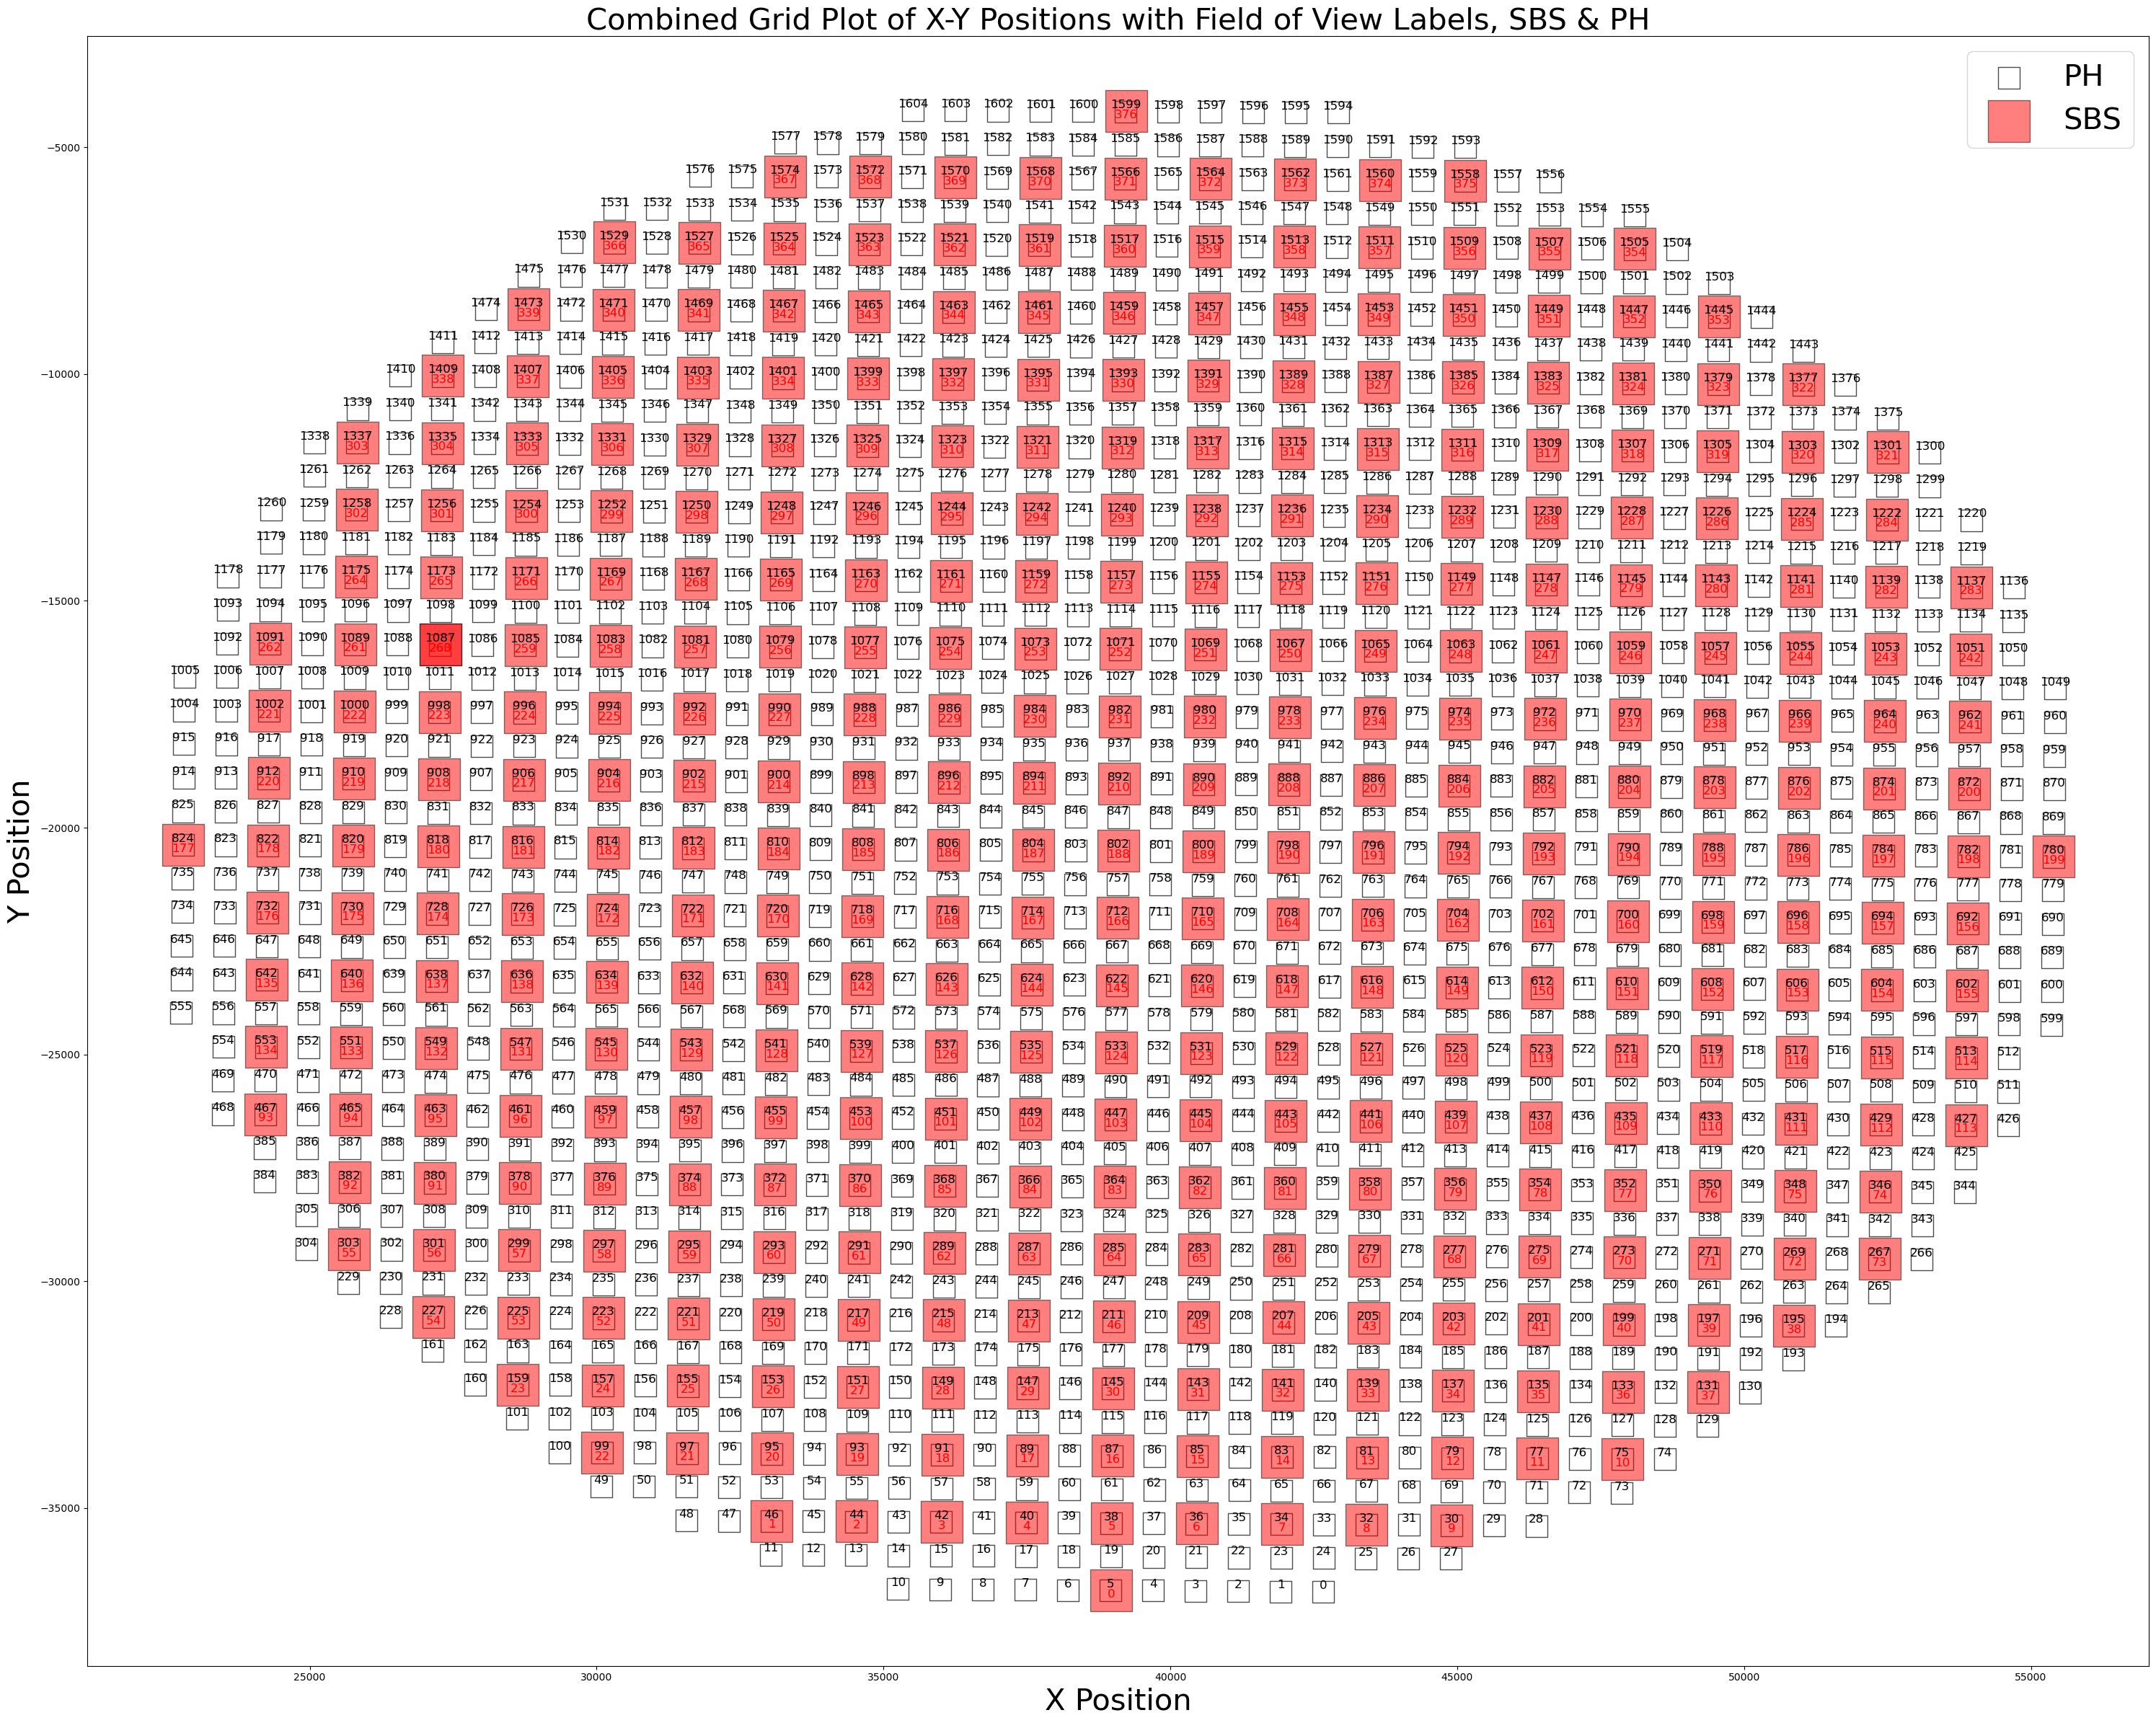

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# load phenotype and SBS metadata dfs
ph_test_metadata_fp = (
    ROOT_FP
    / "preprocess"
    / "metadata"
    / "phenotype"
    / get_filename({"well": TEST_WELL}, "combined_metadata", "tsv")
)
ph_test_metadata = pd.read_csv(ph_test_metadata_fp, sep="\t")
sbs_test_metadata_fp = (
    ROOT_FP
    / "preprocess"
    / "metadata"
    / "sbs"
    / get_filename(
        {"well": TEST_WELL, "cycle": SBS_METADATA_CYCLE}, "combined_metadata", "tsv"
    )
)
sbs_test_metadata = pd.read_csv(sbs_test_metadata_fp, sep="\t")

# create plot with combined tile view
combined_tile_grid = plot_combined_tile_grid(ph_test_metadata, sbs_test_metadata)
combined_tile_grid.show()

## SET PARAMETERS

### Parameters for testing merge processing

- `INITIAL_SITES`: Combinations of phenotype and SBS tiles used for configuring merge module parameters. Based on the combined grid above, set 6 aligned intial sites. We will load images for one of those sites, to ensure that we can visualize cell patterns (using the DAPI channel) that correspond between two tiles that will make up our initial sites. We recommend using aligned sites from across the plate.

In [5]:
INITIAL_SITES = [[5, 0], [141, 32], [370, 86], [896, 212], [1163, 270], [1599, 376]]

In [6]:
# Derive sites for phenotype and sbs
phenotype_tiles = [site[0] for site in INITIAL_SITES]
sbs_tiles = [site[1] for site in INITIAL_SITES]

# Derive phenotype alignment hash
phenotype_info_fp_template = (
    ROOT_FP
    / "phenotype_process"
    / "tsvs"
    / get_filename({"well": TEST_WELL, "tile": "{tile}"}, "phenotype_info", "tsv")
)
phenotype_info_dfs = [
    pd.read_csv(str(phenotype_info_fp_template).format(tile=tile), sep="\t")
    for tile in phenotype_tiles
]
phenotype_info_df = pd.concat(phenotype_info_dfs)
phenotype_info_hash = hash_process_info(phenotype_info_df)

# Derive SBS alignment hash
sbs_info_fp_template = (
    ROOT_FP
    / "sbs_process"
    / "tsvs"
    / get_filename({"well": TEST_WELL, "tile": "{tile}"}, "sbs_info", "tsv")
)
sbs_info_dfs = [
    pd.read_csv(str(sbs_info_fp_template).format(tile=tile), sep="\t")
    for tile in sbs_tiles
]
sbs_info_df = pd.concat(sbs_info_dfs)
sbs_info_hash = hash_process_info(sbs_info_df).rename(columns={"tile": "site"})

# Perform alignment for initial sites
initial_alignment_df = initial_alignment(
    phenotype_info_hash, sbs_info_hash, initial_sites=INITIAL_SITES
)
initial_alignment_df

,rotation,translation,score,determinant,site,tile
0,"[[0.24956369541813928, 1.1898253378914557e-06]...","[300.6698458936717, 300.15906253412766]",0.648264,0.062283,0,5
1,"[[0.24932252844344568, -3.278725576572886e-05]...","[301.10780347570534, 300.93115066410724]",0.665453,0.062155,32,141
2,"[[0.24954763200385544, -0.00012427222521320093...","[301.1852868664773, 301.2433402765184]",0.657020,0.062204,86,370
3,"[[0.2493205625002408, 1.5119321442406391e-05],...","[301.13569198455116, 301.52065966625594]",0.723926,0.062160,212,896
4,"[[0.24937407448699062, 5.668153015062816e-06],...","[300.9148577782966, 302.0004721763743]",0.680449,0.062180,270,1163
5,"[[0.24940271599036928, 1.1739513726732553e-05]...","[300.8926342444916, 302.3825697847199]",0.678253,0.062196,376,1599


## SET PARAMETERS

### Visualize gating strategy based on initial alignment

- `DET_RANGE`: Enforces valid magnification ratios between phenotype and genotype images. It needs to be adjusted based on:
    - Objective magnifications used (e.g., 20X vs 10X)
    - Camera binning settings (e.g., 2x2 binning vs unbinned)
    - To calculate for your setup:
        1. Determine total magnification difference (objectives × binning)
        2. Use (min/difference², max/difference²) where min/max are typically 0.9-1.15
    - You can narrow or expand the suggested `DET_RANGE` based on how closely or widely you want to ensure matches
- `SCORE` This parameter is the score of the transformation, typically 0.1

In [7]:
DET_RANGE = [0.06, 0.065]
SCORE = 0.1

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Alignment Quality Check\nScore vs Determinant'}, xlabel='Determinant', ylabel='Score'>)

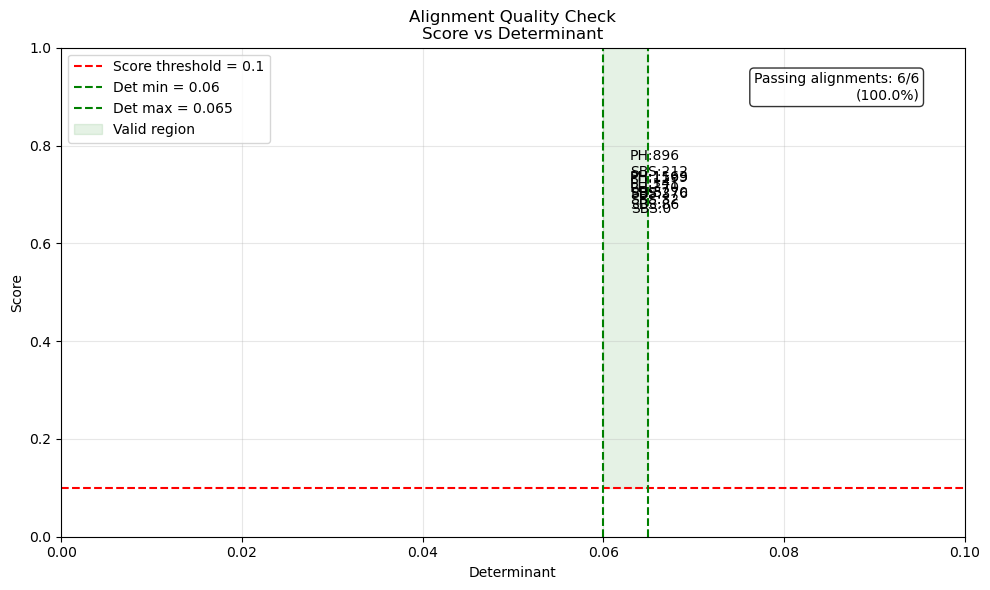

In [8]:
plot_alignment_quality(
    initial_alignment_df, det_range=DET_RANGE, score=SCORE, xlim=(0, 0.1), ylim=(0, 1)
)

## SET PARAMETERS

### Visualize cell matches based on initial alignment

- `THRESHOLD`: Determines the maximum euclidean distance between a phenotype point and its matched SBS point for them to be considered a valid match

In [9]:
THRESHOLD = 2

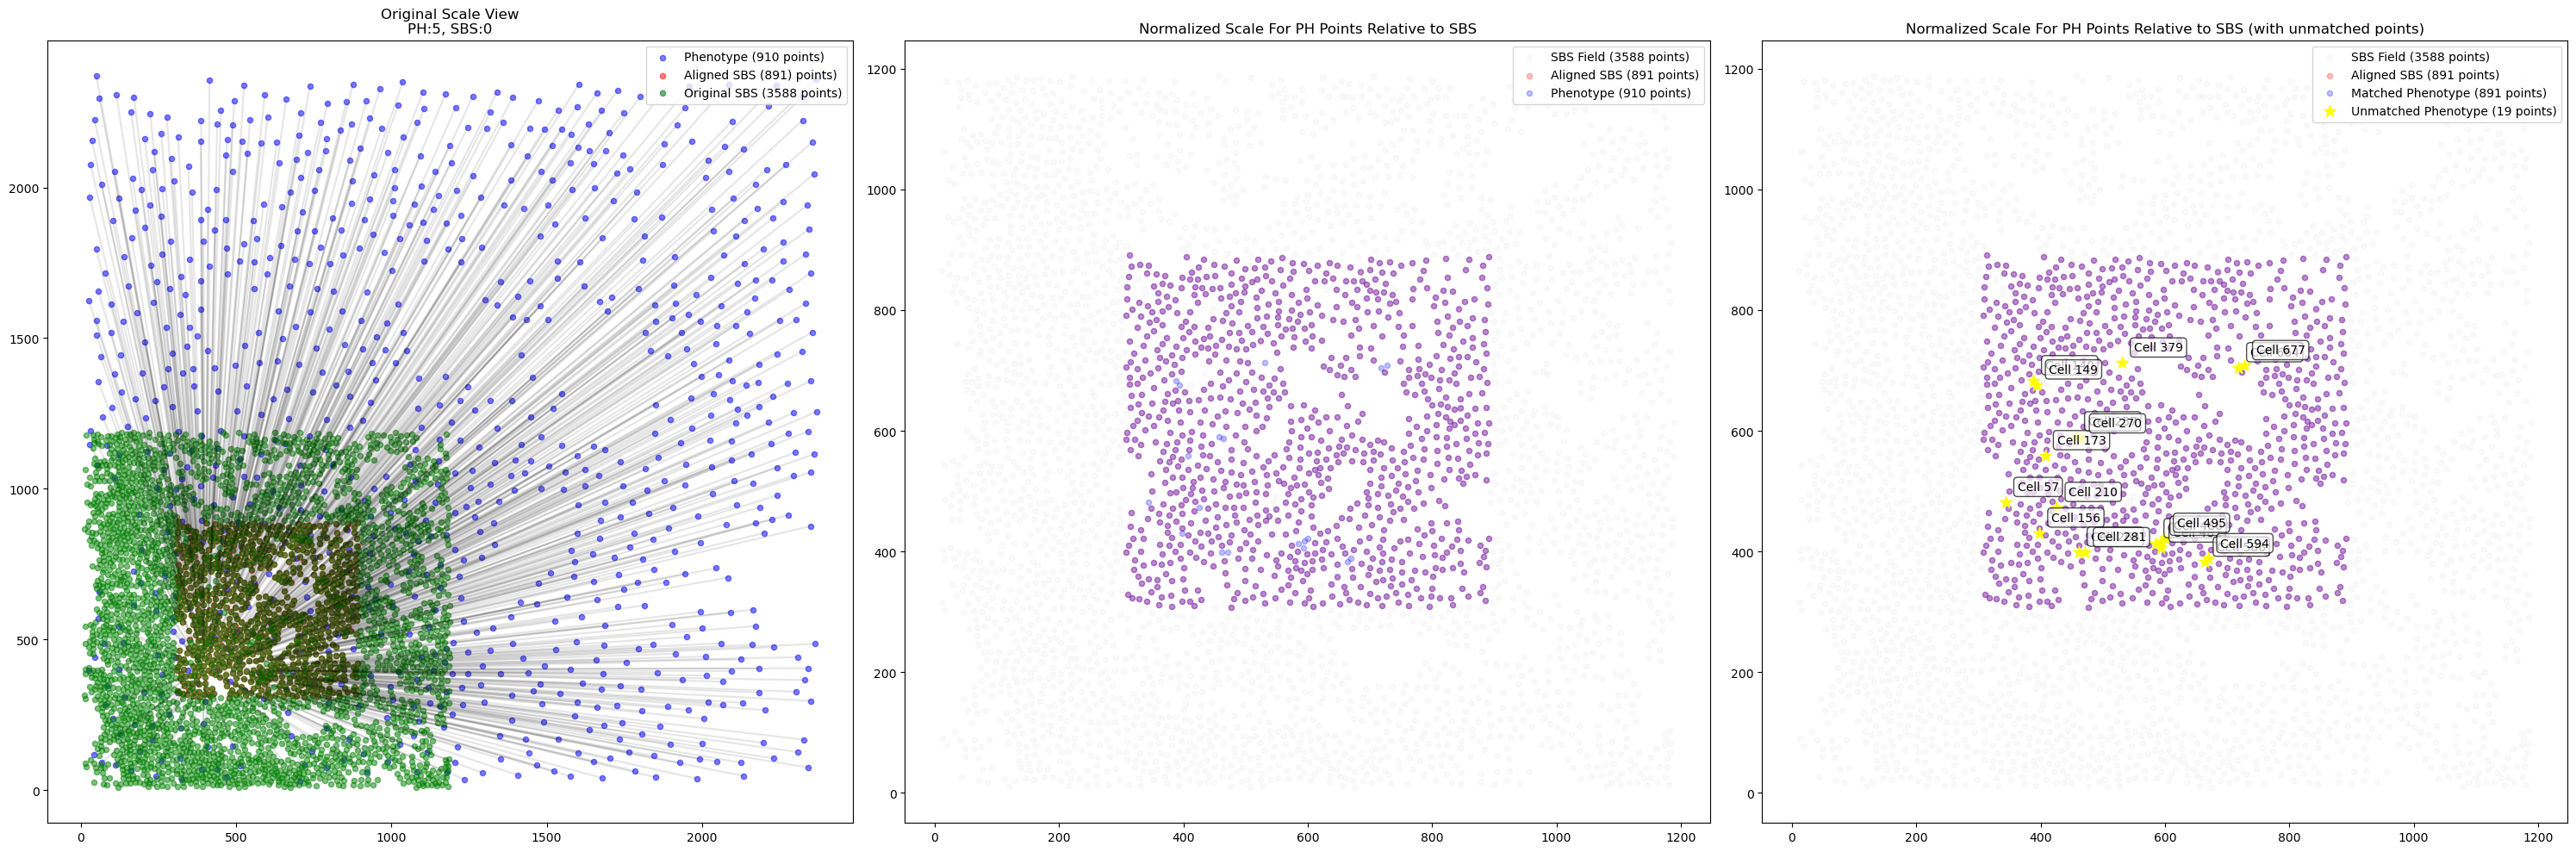

In [10]:
tile_mask = initial_alignment_df["tile"] == INITIAL_SITES[0][0]
site_mask = initial_alignment_df["site"] == INITIAL_SITES[0][1]
alignment_vec = initial_alignment_df[tile_mask & site_mask].iloc[0]

plot_merge_example(
    phenotype_info_df,
    sbs_info_df,
    alignment_vec,
    threshold=THRESHOLD,
)

## Add merge parameters to config file

In [11]:
# Add phenotype_process section
config["merge_process"] = {
    "sbs_metdata_cycle": SBS_METADATA_CYCLE,
    "initial_sites": INITIAL_SITES,
    "det_range": DET_RANGE,
    "score": SCORE,
    "threshold": THRESHOLD,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)